In [146]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
import pandas as pd, os, glob
sn.set_context('notebook')

# ECOREG basic data exploration

This notebook documents preliminary exploration of the **German** ECOREG data supplied by Daniel Herring. The raw data can be found here:

K:\Avdeling\311 Biologisk mangfold - ferskvann ny\SSC\ECOREG

## 1. Data tidying and restructuring

### 1.1. File naming conventions

Firstly, the site numbers do not seem to match between the water quality/ecology sampling locations and the flows data. Linkages must therefore be inferred from the site names, but this requires some minor changes to the file naming conventions used by the raw data. Start by copying the raw data locally and making the following changes to the flows file names:

  1. Changed all site names to lower case
  2. Changed wiedenau_2 to wiedenau2.
  3. Changed hagen_eckesey to hagen-eckesey and hagen_haspe to hagen-haspe.
  4. Changed Nespen.Qpeg.15.zrx to nespen_Qpeg_15.zrx

Next, adjust the site names in the *Overview* sheet of *sites_and_ecol.xlsx* to match the naming conventions above. Also remove the superscript '2's in the column names of the *overview (detail)* sheet, as these are awkward to manipulate in code.

### 1.2. Flows data

The raw data consists of 15-minute resolution discharge data from 31 sites in Germany. The datasets are in different file formats (.zrx and .csv) and use different date formats, as well as different delimiters for both the column and decimal separators. The code below parses the data and plots monthly average flows for each site.

In [147]:
# Define function to perform parsing and resampling

def read_resample_flows(file_name, 
                        site_name,
                        skiprows=11,
                        sep=';',
                        decimal=',',
                        index_col=False,
                        dt_format='%d.%m.%Y %H:%M:%S',
                        freq='M'):
    """ Reads flows data and resamples to the specified frequency.
    
    Args:
        file_name  File to parse
        site_name  Name of site
        skiprows   Number of rows to skip at start
        sep        Column separator
        decimal    Decimal separator
        dt_format  String specifying date format
        freq       Resampling frequency. 'D'=daily; 'M'=monthly; 'A'=Annual
    
    Returns:
        Data frame.
    """
    df = pd.read_csv(file_name, 
                     skiprows=skiprows,
                     header=None,
                     names=['Date_Time', 'Q_m3/s'],
                     index_col=False,
                     sep=sep,
                     decimal=decimal) 
    
    # Parse dates
    df.index = pd.to_datetime(df['Date_Time'], format=dt_format)
    del df['Date_Time']
    
    # Resample
    df = df.resample(freq).mean()
    df.reset_index(inplace=True)
    
    # Add site name as extra column
    df['Site'] = site_name
    df = df[['Site', 'Date_Time', 'Q_m3/s']]
    
    return df

In [148]:
# Process flows data

###############################################################################
# User input
in_fold = r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG\Raw_Data\Germany'
out_csv = r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG\monthly_flows.csv'
# Frequency for resampling
freq = 'M'
###############################################################################
  
# Get list of flow files to process
search_path = os.path.join(in_fold, 'Flows', '*')
file_list = glob.glob(search_path)

# Read files
df_list = []
for file_name in file_list:
    # Get site name
    site_name = os.path.split(file_name)[1].split('_')[0]
    
    # Process differently according to file extension and file formatting
    if site_name == 'hagen-eckesey':
        # This site has a different date format to the other CSV files
        df = read_resample_flows(file_name,
                                 site_name,
                                 skiprows=11,
                                 sep=';',
                                 decimal='.',
                                 dt_format='%d.%m.%Y %H:%M',
                                 freq=freq)        
        df_list.append(df)
        
    elif file_name[-3:] == 'csv':
        # The rest of the CSV files are consistent
        df = read_resample_flows(file_name,
                                 site_name,
                                 skiprows=11,
                                 sep=';',
                                 decimal=',',
                                 dt_format='%d.%m.%Y %H:%M:%S',
                                 freq=freq)        
        df_list.append(df)
        
    elif file_name[-3:] == 'zrx':
        # The ZRX files are also consistent
        df = read_resample_flows(file_name,
                                 site_name,
                                 skiprows=5,
                                 sep=' ',
                                 decimal='.',
                                 dt_format='%Y%m%d%H%M%S',
                                 freq=freq)        
        df_list.append(df)
                
    else:
        raise ValueError('Unexpected file types found in flows data folder.')

# Concatenate results
flows_df = pd.concat(df_list, axis=0)

# Pivot and write output
flows_df = flows_df.pivot(index='Date_Time', columns='Site', values='Q_m3/s')
flows_df.to_csv(out_csv)

# Print first 5 rows of restructured flows table
print flows_df.head()

Site        altenburg  attendorn   bamenohl  beddelhausen  boerlinghausen  \
Date_Time                                                                   
2002-11-30  26.230849  18.305377  19.737756     18.490204        2.889569   
2002-12-31  11.125165   7.045729  13.901247     13.825073        2.817475   
2003-01-31  28.634972  24.993858  27.295978     22.865725        3.238393   
2003-02-28  14.495826   7.792362   9.200878      5.525933        0.876088   
2003-03-31   6.954155   5.549946  12.735974     11.503120        1.736182   

Site        bredelar      broel    bueren  geisbach    gemuend    ...     \
Date_Time                                                         ...      
2002-11-30  2.778607   8.367281  2.673279  1.327665   9.301687    ...      
2002-12-31  1.176407   8.643544  1.766125  1.006928   5.342507    ...      
2003-01-31  3.549792  11.888413  5.042093  1.479826  10.533365    ...      
2003-02-28  1.346269   5.664822  2.031669  0.802001   4.867794    ...      
2003

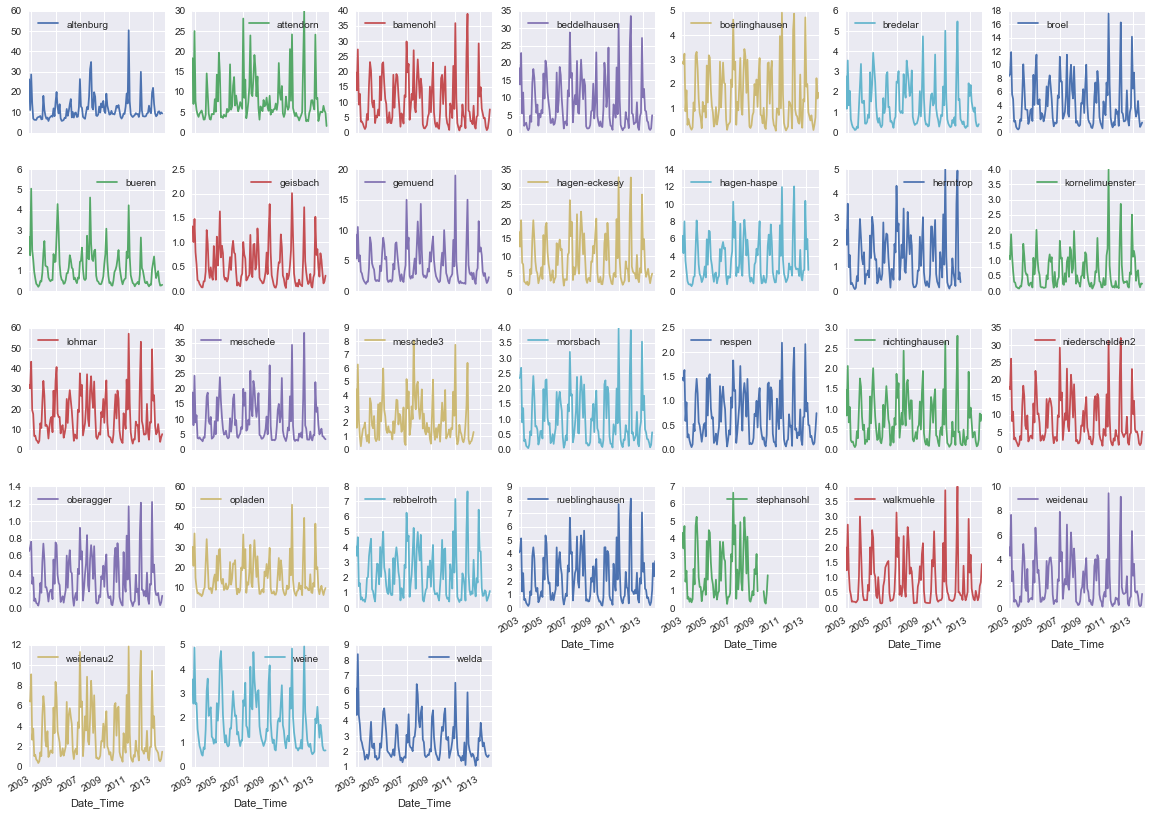

In [149]:
# Plot
flows_df.plot(subplots=True, layout=(5, 7), figsize=(20, 15), sharex=True)
plt.subplots_adjust(hspace=0.3)
plt.show()

The above plots show that, after resampling using monthly averages, we have data for most of the sites from 2003 to 2013 inclusive. Some sites also have slightly more recent data. **Stephansohl** is the only location with significant data gaps at monthly resolution.

It is also often interesting to plot the flow regime from each site, normalised by catchment area. To do this, we first need to extract the site properties from *sites_and_ecol.xlsx*.

**NB:** The *overview (detail)* sheet of *sites_and_ecol.xlsx* includes two different columns for catchment area. I assume one of these is the "official" gauged area and the other comes from someone else's catchment delineation procedure (?). In the code below, I'm assuming the values in the $km^2\_gauge$ column are correct.

In [150]:
# Get catchment areas for each site

# Input file
in_xlsx = r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG\Raw_Data\Germany\sites_and_ecol.xlsx'

# Read adjusted site names and catchment areas
names_df = pd.read_excel(in_xlsx, sheetname='overview')
areas_df = pd.read_excel(in_xlsx, sheetname=' overview (detail)')

# Inner join on site ID
sites_df = pd.merge(names_df, areas_df, how='inner', on='ID_RS')

# Extract columns of interest
sites_df = sites_df[['Site', 'km2_gauge']].drop_duplicates()
sites_df.index = sites_df['Site']
del sites_df['Site']

print sites_df

                 km2_gauge
Site                      
altenburg           958.76
attendorn           332.23
bamenohl             28.71
beddelhausen        356.00
boerlinghausen       47.98
bredelar            251.60
broel               216.00
bueren              170.05
geisbach             48.90
gemuend             344.55
hagen-eckesey       425.00
hagen-haspe         156.00
herrntrop            60.70
kornelimuenster      65.02
lohmar             1335.11
meschede            426.06
meschede3            96.28
morsbach             43.12
nespen               29.40
nichtinghausen       37.17
niederschelden2     431.00
oberagger            12.50
opladen             606.00
rebbelroth          110.40
rueblinghausen       86.00
stephansohl          95.60
walkmuehle           48.22
weidenau            287.00
weidenau2           153.00
weine               143.32
welda               433.73


We can now use this information to area-scale the flows data.

**NB:** Hovering the mouse over the plot below should show options for panning and zooming in the bottom-left corner.

In [151]:
# Plot area-scaled flow data for each site

# Copy the flows data
scaled_df = flows_df.copy()

# Scale each site by its catchment area
for site in scaled_df.columns:
    site_area = sites_df.ix[site, 'km2_gauge']
    scaled_df[site] = scaled_df[site] / site_area

# Plot
scaled_df.plot(legend=False)
mpld3.display()

The plot above is interesting: 30 out of the 31 sites plot approximately together, indicating similar runoff regimes. One of the sites (the red line above) is clearly very different. We can identify this site by calculating the mean of each data series and sorting from largest to smallest:

In [152]:
print scaled_df.mean().sort_values(ascending=False).head(1)

Site
bamenohl    0.338062
dtype: float64


So, the unusual site is **Bamenohl**. Looking at the matrix plot above, it is clear that something strange is going on at this location: the flows at Bamenohl are approximately as large as at Attendorn, but Attendorn has a catchment area of $332 \; km^2$, compared to just $29 \; km^2$ for Bamenohl.

The plot below is the same as the one above, but with the Bamenohl data series removed. This makes it easier to explore the other datasets. (As above, use the pan and zoom tools to make the data clearer).

In [153]:
# Remove Bamenohl
del scaled_df['bamenohl']

# Plot
scaled_df.plot(legend=False)
mpld3.display()

On this plot, there is some evidence of flow regulation, temporal lags etc. at some of the sites, but the overall water balances are quite similar between locations. Some key questions for the flows data:

  1. What do we know about the flow regime at each of these sites? The ECOREG proposal identifies four different classes of flow regulation (*Fig. 1* of the proposal). Are we hoping to infer these classes directly from the hydrographs (above), or do we have additional data to characterise the hydromorphology? <br><br>
  
  2. Do we know what's going on at Bamenohl?
  
### 1.3. Chemistry data

*sites_and_ecol.xlsx* contains water chemistry and ecology data for each of the sites. This section focuses on the data in the *chemistry* sheet.

**NB:** The *chemistry* sheet includes duplicates for some location-time-determinand combinations. It looks as though some of the data has been entered twice, but with slightly different values. For the preliminary analysis below, I'm simply ignoring these duplicates, but **this needs checking**.

**NB2:** The original file contains lots of non-ASCII characters. For simplicity, it's probaly worth removing these before any more detailed analysis, but for now I've just encoded the output using UTF-8.

**NB3:** What does the *Kennung* column in the *chemistry* sheet refer to?

In [154]:
# Output file to create
chem_csv = r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG\chemistry.csv'

# Read chemistry data
chem_df = pd.read_excel(in_xlsx, sheetname='chemistry')

# Join in site names
chem_df = pd.merge(chem_df, names_df, how='left', on='ID_RS')

# Concatenate determinands and units
chem_df['Det'] = chem_df['Parameter_cg'].map(unicode) + ' ' + chem_df['Einheit_cg']

# Extract columns of interest
chem_df = chem_df[['Site', 'Datum', 'Det', 'Wert_cg']]

# Drop duplicates. NB: This is a fudge. CHECK DATA ISSUES with Jannicke/Susi
chem_df = chem_df.drop_duplicates(subset=['Site', 'Datum', 'Det'])

# Rename columns
chem_df.columns = ['Site', 'Date', 'Det', 'Value']

# Build multi-index
chem_df.index = [chem_df['Site'], chem_df['Date'], chem_df['Det']]
del chem_df['Site'], chem_df['Date'], chem_df['Det']

# Unstack determinand
chem_df = chem_df.unstack(level='Det')

# Write output
chem_df.to_csv(chem_csv, encoding='utf-8')

print chem_df.head()

                                      Value                                    \
Det                                AFS mg/l AFS ug/l Ca mg/l Cl mg/l DOC mg/l   
Site           Date                                                             
altenburg      2009-08-31 15:00:00      3.0      NaN     NaN    27.0      NaN   
attendorn      2013-07-08 00:00:00      0.0      0.0     0.0     0.0      0.0   
bamenohl       2014-07-03 00:00:00      1.0      NaN     0.0     0.0      NaN   
beddelhausen   2010-08-15 15:00:00      NaN      NaN    20.0    20.4      NaN   
boerlinghausen 2013-07-17 00:00:00      0.0      0.0     0.0     0.0      0.0   

                                                              \
Det                                Fe mg/l GH mg/l GH mmol/l   
Site           Date                                            
altenburg      2009-08-31 15:00:00    0.11     NaN       NaN   
attendorn      2013-07-08 00:00:00     NaN     NaN       0.0   
bamenohl       2014-07-03 00:00

Looking at the table above, there are between 1 and 3 sets of chemistry samples for each site (and the same looks to be true for the ecology data). An approximate sampling time is given for some of the chemistry measurements, but not for others. A key question is therefore **how to link the chemistry and ecology data to the high resolution hydrology data?** For example, we could use daily, monthly or annual average hydrology (or some other statistic), depending on how representative we think the water chemistry and ecology data are of the wider flow regime.

I don't know much about ecology, but water chemistry is usually strongly correlated with flow, so I'd be wary of trying to match long-term hydrological averages to just a few chemistry samples.

### 1.4. Ecology data

I haven't looked at this yet. Perhaps next week we can discuss what the ecological indices mean for the different taxa and whether we should be considering each measurement separately or aggregating them into some kind of overall ecological score. Keeping the data separate preserves detail, but will likely lead to an **overparameterised** statistical model. Some level of aggregation will therefore almost certainly be required, but how much is something for further discussion. If necessary, we can use e.g. **feature selection** or a **clustering algorithm** to determine a suitable level of aggregation from the data itself, but a bit of ecological guidance/intuition will likely lead to a better model.

## 2. Indicators of Hydrologic Alteration

Rather than use the four hydromorphological classes in *Fig. 1* of the original proposal, Susi has suggested applying the **Indicators of Hydrologic Alteration** methodology described here:

Richter, B.D., Baumgartner, J.V., Powell, J., Braun, D.P. 1996. *[A method for assessing hydrologic alteration within ecosystems](http://emerald.tufts.edu/water/pdf/iha_meth.pdf)*. Conserv. Biol. **10**, 1163–1174.

(See Susi's e-mail from 26/04/2016 at 15:31 for more details).

These authors describe 32 statistical indices of morphological alteration that can estimated directly from the hydrograph. The same authors have also produced software called [IHA](https://www.conservationgateway.org/ConservationPractices/Freshwater/EnvironmentalFlows/MethodsandTools/IndicatorsofHydrologicAlteration/Pages/indicators-hydrologic-alt.aspx), which automates the calculation procedure based on time series of **daily average flows**. This software package provide lots of functionality and a nice GUI, but unfortunately it does not have a command line interface. We therefore have two options:

  1. **Use Python to generate a batch input file** for all the ECOREG sites in the format specified in section 3.2.4 of the [IHA documentation](https://www.conservationgateway.org/ConservationPractices/Freshwater/EnvironmentalFlows/MethodsandTools/IndicatorsofHydrologicAlteration/Documents/IHAV7.pdf). This will be easy to do, and the IHA program should then make it straightforward to calculate the statistics of interest. <br><br>
  
  2. **Recode the IHA methodology into Python**. Most of the metrics look straightforward to calculate, so it would be interesting to see whether this can be implemented fairly quickly. What's more, the IHA software hasn't been updated since 2009, but the methodology is still applied widely in the literature. A Python implementation might therefore be of interest to other researchers, as well as being potentially useful for us (assuming this kind of analysis is something NIVA might want to do again).
  
**Possible paper idea:** Create an open source Python package based on the IHA methodology and make it available for download via [PyPi](https://pypi.python.org/pypi). Document the code and present an illustrative application using the ECOREG data. This could make a nice publication for e.g. [Environmental Modelling and Software](http://www.journals.elsevier.com/environmental-modelling-and-software/).

To test the feasibility of recoding the IHA methodology, the code below uses the tutorial dataset for **Roanoke River**, as supplied with the IHA software. If my simple Python implementation gives the same result as the IHA software demonstration, it should be relatively simple to refine the code and make it more widely available.

The 32 IHA indicators are divided into five groups:

  1. Magnitude
  2. Magnitude and duration of annual extremes
  3. Timing of annual extremes
  4. Frequency and duration of high and low pulses
  5. Rate and frequency of change in conditions

In [155]:
# Read the IHA tutorial dataset

iha_csv = r'C:\Data\IHA71_En\Roanoke_River_NC_02080500_cms.csv'

df = pd.read_csv(iha_csv)

# Convert to dates and use dates as index
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.index = df['Date']
del df['Date']

# Print first 5 rows
print df.head()

            Flow
Date            
1912-01-01   257
1912-01-02   323
1912-01-03   309
1912-01-04   282
1912-01-05   269


### 2.1. Group 1: Magnitude (monthly summaries)

The first 12 indicators in the IHA methodology are **monthly medians** (and **coefficients of dispersion**) of all the daily flows in each month of each year.

In [156]:
# Truncate data before first October and after last September

# Get first and last years
st_yr = df.index[0].year
end_yr = df.index[-1].year

# Truncate
df = df.truncate(before='%s-10-01' % st_yr, after='%s-09-30' % end_yr)

print df.head()
print '\n'
print df.tail()

            Flow
Date            
1912-10-01   101
1912-10-02   101
1912-10-03    83
1912-10-04    83
1912-10-05    74


            Flow
Date            
2004-09-26   191
2004-09-27   253
2004-09-28   239
2004-09-29   236
2004-09-30   354


In [157]:
# Resample to monthly, taking medians
df = df.resample('M').median()

# Add columns for month and year
df['Year'] = df.index.year
df['Month'] = df.index.month

print df.head()

             Flow  Year  Month
Date                          
1912-10-31   74.0  1912     10
1912-11-30   88.0  1912     11
1912-12-31   92.0  1912     12
1913-01-31  146.0  1913      1
1913-02-28  121.0  1913      2


It is usual to define the hydrological year for year $x$ as as running from **October 1st** in year $(x - 1)$ to **September 30th** in year $x$. This means the **Year** column in the data frame above is not quite right - *the median for October 1912 actually belongs to the 1913 hydrological year*. This can be corrected by shifting the years column back three steps and then forward-filling NaNs at the end of the series

In [158]:
# Align data with hydrological years
df['Year'] = df['Year'].shift(-3).fillna(method='ffill')

print df.head()
print '\n'
print df.tail()

             Flow    Year  Month
Date                            
1912-10-31   74.0  1913.0     10
1912-11-30   88.0  1913.0     11
1912-12-31   92.0  1913.0     12
1913-01-31  146.0  1913.0      1
1913-02-28  121.0  1913.0      2


             Flow    Year  Month
Date                            
2004-05-31  227.0  2004.0      5
2004-06-30  228.0  2004.0      6
2004-07-31  134.0  2004.0      7
2004-08-31  240.0  2004.0      8
2004-09-30  280.5  2004.0      9


The next stage is to **pivot** the data into a grid, from which overall **medians** and **coefficients of dispersion** can be calculated.

In [159]:
# Pivot
df = df.pivot(index='Year', columns='Month', values='Flow')

# Re-order columns so that Oct, Nov, Dec are listed first
df = df[[10, 11, 12,] + range(1, 10)]

print df.head(10)

Month      10     11     12     1      2      3      4      5      6      7   \
Year                                                                           
1913.0   74.0   88.0   92.0  146.0  121.0  257.0  199.0  121.0  193.5  106.0   
1914.0  106.0  125.5  166.0  210.0  330.0  323.0  233.0  135.0   74.0  141.0   
1915.0   70.0   70.0  309.0  416.0  309.0  233.0  188.0  125.0  130.0   88.0   
1916.0  172.0   90.0  103.0  230.0  230.0  161.0  136.0  122.0  218.0  230.0   
1917.0   83.0   75.0   90.0  243.0  206.0  450.0  206.0  161.0  124.0  151.0   
1918.0   64.0   74.0   46.0  125.0  309.0  199.0  376.5  244.0  106.0   97.0   
1919.0   58.0  115.5  244.0  282.0  210.0  282.0  210.0  295.0  210.0  233.0   
1920.0   88.0   78.0   97.0  106.0  233.0  244.0  263.0  135.0  140.5  125.0   
1921.0   64.0   91.0  354.0  283.0  333.0  227.0  207.5  178.0  118.0  109.0   
1922.0   46.0  100.0  105.0  138.0  400.5  487.0  201.0  269.0  214.0  201.0   

Month      8      9   
Year            

We can now calculate medians and coefficients of dispersion, where the IHA software defines the latter as the IQR divided by the median:

$$C_d = \frac{P_{75} - P_{25}}{P_{50}}$$

In [160]:
# Get quantiles
qtiles = df.quantile([0.25, 0.5, 0.75], axis=0, interpolation='linear').T

# Coefficient of dispersion
qtiles['CoD'] = (qtiles[0.75] - qtiles[0.25]) / qtiles[0.5]

print qtiles[[0.5, 'CoD']]

          0.5       CoD
Month                  
10      89.00  0.971910
11     118.25  0.735729
12     162.00  0.845679
1      225.00  0.786667
2      256.25  0.701951
3      245.00  0.943878
4      227.50  0.741758
5      179.50  0.658774
6      162.75  0.682028
7      113.00  0.590708
8      106.00  0.933962
9       93.25  0.774799


These results are very close - but not identical - to the ones estimated by the IHA software. The values in the data frame (*df*, above) are the same, and the medians are identical, but there is some disagreement in the 25th and 75th quartiles (and therefore in the CoD). It is the IHA software that is giving strange results: my code is consistent with both Excel and Access. Section 5.2 of the IHA software handbook states that they are using the International Mathematical and Statistical
Library (IMSL) to estimate percentiles, and that this approach differs from other methods. I can't find a description of the ISML's approach, but for now I'm happy with the method I'm currently using, which seems pretty well-accepted.

### 2.2. Group 2: Magnitude and duration (moving window operations)

The statistics in this group involve moving window operations over 1, 7, 30 and 90 days. The median and CoD of the minimum and maximum values in each year are then calculated.

In [161]:
# Read raw data again
df = pd.read_csv(iha_csv)

# Convert to dates and use dates as index
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.index = df['Date']
del df['Date']

# Print first 5 rows
print df.head()

            Flow
Date            
1912-01-01   257
1912-01-02   323
1912-01-03   309
1912-01-04   282
1912-01-05   269


Now apply moving window, resample to annual frequency and get the percentiles over all years.

In [162]:
df_list = []

# Loop over window lengths
for win in [1, 7, 30, 90]:
    # Loop over statistics
    for stat in ['min', 'max']:
        # Apply window, resample, get max
        if stat == 'min':
            win_df = df.rolling(window=win).mean().resample('A').min()
        else:
            win_df = df.rolling(window=win).mean().resample('A').max()

        # Get quantiles
        win_qtiles = win_df.quantile([0.25, 0.5, 0.75], axis=0, interpolation='linear').T

        # Coefficient of dispersion
        win_qtiles['CoD'] = (win_qtiles[0.75] - win_qtiles[0.25]) / win_qtiles[0.5]
        
        # Extract columns of interest
        win_qtiles = win_qtiles[[0.5, 'CoD']]
        
        # Rename index
        win_qtiles.index = ['%02d_%s' % (win, stat)]
        
        df_list.append(win_qtiles)

# Concat dfs
grp2_df = pd.concat(df_list, axis=0)

print grp2_df

               0.5       CoD
01_min   33.000000  0.727273
01_max  977.000000  1.179120
07_min   55.857143  0.386189
07_max  724.571429  0.729101
30_min   72.300000  0.396496
30_max  542.600000  0.526293
90_min  102.166667  0.453290
90_max  393.422222  0.471193


As above, these results are very similar, but not identical, to those obtained from the IHA software. The differences seem to be due to IHA using an unusual method for interpolating percentiles, but I'll need to **check this in more detail at some point**.

### 2.3. Group 3: Timing of annual extremes

This group of indicators comprises the day of the year ("Julian day") for the maximum and minimum average daily flow. These statistics are easy to calculate for each year, but direct averaging over multiple years gives rather arbitrary results. For example, if the maximum flow falls on December 31st in one year and January 2nd on another, the arithmetic average of these values should intuitively be January 1st. However, the basic methodology implemented by the IHA software implies an average of $\frac{(366 + 2)}{2} = 184$, which is in July. To solve this, IHA applies lots of shifting and lagging to any calculations close to the year end (see section 5.3 of the [IHA manual](https://www.conservationgateway.org/ConservationPractices/Freshwater/EnvironmentalFlows/MethodsandTools/IndicatorsofHydrologicAlteration/Documents/IHAV7.pdf) for details), but this approach is fairly arbitrary and doesn't necessarily produce consistent results.

A better appraoch would be to use **[circular statistics](https://en.wikipedia.org/wiki/Mean_of_circular_quantities)**, as is implemented in e.g. [`scipy.stats.circmean`](http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.stats.circmean.html).

In [163]:
from scipy.stats import circmean

# For a non-leap year, the average of 31/12 and 02/01 should be 01/01
print circmean([365, 2], high=365, low=0)

1.0


This seems to work, so the it looks as though the IHA methodology could be improved by using `circmean`. 

Before going any further with the Python implementation, we had a meeting which led to...

## 3. R-interface

During the meeting on 02/05/2016, Jannicke found an [R package](http://deq2.bse.vt.edu/sifnwiki/index.php/R_iha) that implements the IHA calculations. This package is a little outdated and getting it installed with a recent version of R requires a bit of hacking. Once installed, however, it provides a reasonably simple way of estimating the IHA indicators.

**NB:** Given the difficulties getting this installed on R, a Python verion may still be worth considering?

**NB2:** The code below calculates **circular means** (not medians) for the group 3 indicators.

### 3.1. Read test data again

As an initial test of the R package, we'll start off again with the raw IHA dataset, truncated to span a whole number of water years.

In [164]:
# Read raw data again
df = pd.read_csv(iha_csv)

# Convert to dates and use dates as index
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.index = df['Date']
del df['Date']

# Truncate data before first October and after last September
# Get first and last years
st_yr = df.index[0].year
end_yr = df.index[-1].year

# Truncate
df = df.truncate(before='%s-10-01' % st_yr, after='%s-09-30' % end_yr)

# Add site name for this example
df.columns = ['roanoke_river']

print df.head()
print '\n'
print df.tail()

            roanoke_river
Date                     
1912-10-01            101
1912-10-02            101
1912-10-03             83
1912-10-04             83
1912-10-05             74


            roanoke_river
Date                     
2004-09-26            191
2004-09-27            253
2004-09-28            239
2004-09-29            236
2004-09-30            354


### 3.2. Process data

The code below is rather messy and could be **tidied up a lot**. This is just to test the link between Python and R with the IHA package.

In [165]:
def process_iha(df):
    """ Processes the first five groups of IHA indicators.
    
    Args:
        df  Pandas data frame with DAILY resolution consisting
            of a single column entitled 'site_name' and a date-time
            index.
    
    Returns:
        Pandas data frame of IHA parameters calculated from the
        IHA R package.
    """
    # Set up connection to R
    import rpy2.interactive as r
    import rpy2.interactive.packages
    import pandas.rpy.common as com
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()

    # Circular mean function from scipy (see above)
    from scipy.stats import circmean

    # Load necessary R packages
    zoo = r.packages.importr('zoo')
    iha = r.packages.importr('IHA')

    # Get path to package methods
    rlib = r.packages.packages

    # Convert df to 2 columns ['Dates', 'Flows']
    df2 = df.reset_index()

    # Convert Pandas df to R 
    ts = rlib.zoo.read_zoo(df2, format="%Y-%m-%d")
    
    # Processing for Group 1
    # Calculate group 1 stats.
    rg1 = rlib.IHA.group1(ts)

    # Convert back to Python
    grp1 = com.convert_robj(rg1)

    # Get stats
    grp1 = grp1.describe().T

    # Coefficient of dispersion
    grp1['CoD'] = (grp1['75%'] - grp1['25%']) / grp1['50%']

    # Format grp 1 df
    grp1.index.name = 'Indicator'
    grp1.reset_index(inplace=True)
    grp1['Group'] = 1
    grp1.index = [grp1['Group'], grp1['Indicator']]
    grp1 = grp1[['50%', 'CoD']]
    
    # Processing for Group 2
    # Calculate group 2 stats.
    rg2 = rlib.IHA.group2(ts)

    # Convert back to Python
    grp2 = com.convert_robj(rg2)

    # Get stats
    grp2 = grp2.describe().T

    # Coefficient of dispersion
    grp2['CoD'] = (grp2['75%'] - grp2['25%']) / grp2['50%']

    # Format grp 2 df
    grp2.index.name = 'Indicator'
    grp2.reset_index(inplace=True)
    grp2['Group'] = 2
    grp2 = grp2[grp2['Indicator'] != 'year']
    grp2.index = [grp2['Group'], grp2['Indicator']]
    grp2 = grp2[['50%', 'CoD']]

    # Processing for Group 3
    # Calculate group 3 stats.
    rg3 = rlib.IHA.group3(ts)

    # Convert back to Python
    grp3 = com.convert_robj(rg3)

    # Get stats using circular mean and assuming 366 days per year (as in IHA)
    c_av = circmean(grp3, high=366, low=0, axis=0)
    
    # We won't include a CoD for this stat.
    # Build df to store this info
    grp3 = pd.DataFrame(data=[c_av, [pd.np.nan, pd.np.nan]], 
                        columns=['Min', 'Max'],
                        index=['50%', 'CoD']).T

    # Format grp 2 df
    grp3.index.name = 'Indicator'
    grp3.reset_index(inplace=True)
    grp3['Group'] = 3
    grp3.index = [grp3['Group'], grp3['Indicator']]
    grp3 = grp3[['50%', 'CoD']]

    # Processing for Group 4
    # Calculate group 4 stats.
    rg4 = rlib.IHA.group4(ts)

    # Convert back to Python
    grp4 = com.convert_robj(rg4)

    # Get stats
    grp4 = grp4.describe().T

    # Coefficient of dispersion
    grp4['CoD'] = (grp4['75%'] - grp4['25%']) / grp4['50%']

    # Format grp 4 df
    grp4.index.name = 'Indicator'
    grp4.reset_index(inplace=True)
    grp4['Group'] = 4
    grp4.index = [grp4['Group'], grp4['Indicator']]
    grp4 = grp4[['50%', 'CoD']]  

    # Processing for Group 5
    # Calculate group 5 stats.
    rg5 = rlib.IHA.group5(ts)

    # Convert back to Python
    grp5 = com.convert_robj(rg5)

    # Get stats
    grp5 = grp5.describe().T

    # Coefficient of dispersion
    grp5['CoD'] = (grp5['75%'] - grp5['25%']) / grp5['50%']

    # Format grp 4 df
    grp5.index.name = 'Indicator'
    grp5.reset_index(inplace=True)
    grp5['Group'] = 5
    grp5.index = [grp5['Group'], grp5['Indicator']]
    grp5 = grp5[['50%', 'CoD']]  

    # Combine results
    iha_res = pd.concat([grp1, grp2, grp3, grp4, grp5], axis=0)
    
    # Rename 50% col (because not all values are actually medians)
    # Also add heirarchical index for site_name
    iha_res.columns = [[df.columns[0], df.columns[0]],['Cent_Est', 'CoD']]
   
    return iha_res
    
iha = process_iha(df)
print iha

                        roanoke_river          
                             Cent_Est       CoD
Group Indicator                                
1     October               89.000000  0.971910
      November             118.250000  0.735729
      December             162.000000  0.845679
      January              225.000000  0.786667
      February             256.250000  0.701951
      March                245.000000  0.943878
      April                227.500000  0.741758
      May                  179.500000  0.658774
      June                 162.750000  0.682028
      July                 113.000000  0.590708
      August               106.000000  0.933962
      September             93.250000  0.774799
2     1 Day Min             33.000000  0.651515
      1 Day Max            968.500000  1.328601
      3 Day Min             43.333333  0.496154
      3 Day Max            930.500000  1.113917
      7 Day Min             54.285714  0.438158
      7 Day Max            726.071429  0

Note that the values in the `Cent_Est` column above are based on **medians** where possible, but **means** for the group 3 indicators (calculated using circular statistics). There are also some minor issues with the values in the `CoD` column (e.g. negative numbers for some group 5 indicators). **These need correcting**, but first I'd like to experiment a little with the German flows data.

### 3.3. Process German flows data

To start, we need to re-run the code from the start of this notebook, but this time resampling to **daily** resolution rather than monthly. We'll **remove Stephansohl** from consideration for now as it has significant data gaps. Most of the other sites are complete (with only minor data gaps) from **October 2003 until September 2011**, so we'll truncate all the series there in this analysis. Any remaining data gaps will be filled using **linear interpolation**.

In [166]:
# Process flows data

###############################################################################
# User input
in_fold = r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG\Raw_Data\Germany'
out_csv = r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG\daily_flows.csv'

# Frequency for resampling
freq = 'D'

# Period for consideration
st_yr = 2003
end_yr = 2011

# Ignore the following sites
ig_list = ['stephansohl', ]
###############################################################################
  
# Get list of flow files to process
search_path = os.path.join(in_fold, 'Flows', '*')
file_list = glob.glob(search_path)

# Read files
df_list = []
for file_name in file_list:
    # Get site name
    site_name = os.path.split(file_name)[1].split('_')[0]
    
    # Process differently according to file extension and file formatting
    if site_name == 'hagen-eckesey':
        # This site has a different date format to the other CSV files
        df = read_resample_flows(file_name,
                                 site_name,
                                 skiprows=11,
                                 sep=';',
                                 decimal='.',
                                 dt_format='%d.%m.%Y %H:%M',
                                 freq=freq)        
        df_list.append(df)
        
    elif file_name[-3:] == 'csv':
        # The rest of the CSV files are consistent
        df = read_resample_flows(file_name,
                                 site_name,
                                 skiprows=11,
                                 sep=';',
                                 decimal=',',
                                 dt_format='%d.%m.%Y %H:%M:%S',
                                 freq=freq)        
        df_list.append(df)
        
    elif file_name[-3:] == 'zrx':
        # The ZRX files are also consistent
        df = read_resample_flows(file_name,
                                 site_name,
                                 skiprows=5,
                                 sep=' ',
                                 decimal='.',
                                 dt_format='%Y%m%d%H%M%S',
                                 freq=freq)        
        df_list.append(df)
                
    else:
        raise ValueError('Unexpected file types found in flows data folder.')

# Concatenate results
flows_df = pd.concat(df_list, axis=0)

# Pivot and write output
flows_df = flows_df.pivot(index='Date_Time', columns='Site', values='Q_m3/s')
flows_df.to_csv(out_csv)

# Truncate data before first October and after last September
flows_df = flows_df.truncate(before='%s-10-01' % st_yr, after='%s-09-30' % end_yr)

# Remove selected sites from analysis
for site in ig_list:
    del flows_df[site]
    
# Linear interpolation of data gaps
flows_df.interpolate(method='linear', inplace=True)

# Check there are no missing values in the remaining dataset
assert not flows_df.isnull().values.any()

print flows_df.head()

Site        altenburg  attendorn  bamenohl  beddelhausen  boerlinghausen  \
Date_Time                                                                  
2003-10-01   8.227406   3.193958  1.634333      0.864740        0.264125   
2003-10-02   8.096375   4.579271  3.179583      1.649719        0.601219   
2003-10-03   8.376479   1.276875  2.739792      1.569510        0.700115   
2003-10-04   9.241635   1.536458  8.927812      4.900802        2.871667   
2003-10-05   8.308115   1.192500  6.080937      3.423354        1.574375   

Site        bredelar     broel    bueren  geisbach   gemuend    ...     \
Date_Time                                                       ...      
2003-10-01  0.153990  0.600562  0.287219  0.095740  1.331406    ...      
2003-10-02  0.193146  1.448646  0.364406  0.123885  1.325448    ...      
2003-10-03  0.207073  1.298854  0.349083  0.180427  1.499906    ...      
2003-10-04  0.287385  3.946302  0.829490  0.517021  1.702708    ...      
2003-10-05  0.272365  1

We can now calculate the IHA parameters for each site.

In [167]:
# Output file
iha_csv = r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Susi_S\ECOREG\iha_params.csv'

# DF to store output
df_list = []

# Loop over German sites and calc IHA params
for col in flows_df.columns:
    # Print progress
    print 'Processing: %s.' % col
    
    # Append results
    df_list.append(process_iha(flows_df[[col]]))

# Combine into final output
iha_params = pd.concat(df_list, axis=1)

# Write output
iha_params.to_csv(iha_csv)

print '\n'
print iha_params.head()

Processing: altenburg.
Processing: attendorn.
Processing: bamenohl.
Processing: beddelhausen.
Processing: boerlinghausen.
Processing: bredelar.
Processing: broel.
Processing: bueren.
Processing: geisbach.
Processing: gemuend.
Processing: hagen-eckesey.
Processing: hagen-haspe.
Processing: herrntrop.
Processing: kornelimuenster.
Processing: lohmar.
Processing: meschede.
Processing: meschede3.
Processing: morsbach.
Processing: nespen.
Processing: nichtinghausen.
Processing: niederschelden2.
Processing: oberagger.
Processing: opladen.
Processing: rebbelroth.
Processing: rueblinghausen.
Processing: walkmuehle.
Processing: weidenau.
Processing: weidenau2.
Processing: weine.
Processing: welda.


                 altenburg           attendorn             bamenohl            \
                  Cent_Est       CoD  Cent_Est       CoD   Cent_Est       CoD   
Group Indicator                                                                 
1     October     8.600813  0.536258  6.038542  0.306383  